<a href="https://colab.research.google.com/github/abrham17/Diffusion_model-UNet-implementation/blob/main/Diffusion_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader , Subset
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from pathlib import Path
import time
import datetime

In [ ]:
def space_to_depth(x, size=2):
    b, c, h, w = x.shape
    out_h = h // size
    out_w = w // size
    out_c = c * (size * size)
    x = x.reshape((-1, c, out_h, size, out_w, size))
    x = x.permute((0, 1, 3, 5, 2, 4))
    x = x.reshape((-1, out_c, out_h, out_w))
    return x

class SpaceToDepth(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.size = size
    def forward(self, x):
        return space_to_depth(x, self.size)

class Residual(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
    def forward(self, x, *args, **kwargs):
        return x + self.func(x, *args, **kwargs)

def upsample(in_channels, out_channels=None):
    out_channels = in_channels if out_channels is None else out_channels
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode='nearest'),
        nn.Conv2d(in_channels, out_channels, 3, padding=1)
    )

def downsample(in_channels, out_channels=None):
    out_channels = in_channels if out_channels is None else out_channels
    return nn.Sequential(
        SpaceToDepth(2),
        nn.Conv2d(4 * in_channels, out_channels, 1)
    )


In [ ]:
class SinusodialPositionEmbedding(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim
    def forward(self, time_steps):
        positions = time_steps.unsqueeze(1)
        half_dim = self.embedding_dim // 2
        embeddings = torch.zeros((time_steps.shape[0], self.embedding_dim), device=time_steps.device)
        denominators = 10_000 ** (2 * torch.arange(half_dim, device=time_steps.device) / self.embedding_dim)
        embeddings[:, 0::2] = torch.sin(positions / denominators)
        embeddings[:, 1::2] = torch.cos(positions / denominators)
        return embeddings


In [ ]:
class WeightStandardizedConv2d(nn.Conv2d):
    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3
        weight = self.weight
        mean = weight.mean(dim=[1, 2, 3], keepdim=True)
        variance = weight.var(dim=[1, 2, 3], keepdim=True, correction=0)
        normalized_weight = (weight - mean) / torch.sqrt(variance + eps)
        return F.conv2d(x, normalized_weight, self.bias, self.stride, self.padding, self.dilation, self.groups)

class Block(nn.Module):
    def __init__(self, in_channels, out_channels, groups=8):
        super().__init__()
        self.proj = WeightStandardizedConv2d(in_channels, out_channels, 3, padding=1)
        self.norm = nn.GroupNorm(groups, out_channels)
        self.act = nn.SiLU()
    def forward(self, x, scale_shift=None):
        x = self.proj(x)
        x = self.norm(x)
        if scale_shift is not None:
            scale, shift = scale_shift
            x = x * (scale + 1) + shift
        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, 2 * out_channels)) if time_emb_dim else None
        self.block1 = Block(in_channels, out_channels, groups)
        self.block2 = Block(out_channels, out_channels, groups)
        self.res_conv = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
    def forward(self, x, time_emb=None):
        scale_shift = None
        if self.mlp and time_emb is not None:
            time_emb = self.mlp(time_emb)
            scale_shift = time_emb.view(-1, 2 * self.block2.proj.out_channels, 1, 1).chunk(2, dim=1)
        h = self.block1(x, scale_shift=scale_shift)
        h = self.block2(h)
        return h + self.res_conv(x)

class Attention(nn.Module):
    def __init__(self, in_channels, num_heads=4, dim_head=32):
        super().__init__()
        self.num_heads = num_heads
        self.dim_head = dim_head
        self.scale_factor = dim_head ** -0.5
        self.hidden_dim = num_heads * dim_head
        self.input_to_qkv = nn.Conv2d(in_channels, 3 * self.hidden_dim, 1, bias=False)
        self.to_output = nn.Conv2d(self.hidden_dim, in_channels, 1)
    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.input_to_qkv(x).chunk(3, dim=1)
        q, k, v = map(lambda t: t.view(b, self.num_heads, self.dim_head, h * w), qkv)
        q = q * self.scale_factor
        sim = torch.einsum("b h c i, b h c j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attention = sim.softmax(dim=-1)
        output = torch.einsum("b h i j, b h c j -> b h i c", attention, v)
        output = output.reshape(b, self.hidden_dim, h, w)
        return self.to_output(output)

class LinearAttention(nn.Module):
    def __init__(self, in_channels, num_heads=4, dim_head=32):
        super().__init__()
        self.num_heads = num_heads
        self.dim_head = dim_head
        self.scale_factor = dim_head ** -0.5
        self.hidden_dim = num_heads * dim_head
        self.input_to_qkv = nn.Conv2d(in_channels, 3 * self.hidden_dim, 1, bias=False)
        self.to_output = nn.Sequential(nn.Conv2d(self.hidden_dim, in_channels, 1), nn.GroupNorm(1, in_channels))
    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.input_to_qkv(x).chunk(3, dim=1)
        q, k, v = map(lambda t: t.view(b, self.num_heads, self.dim_head, h * w), qkv)
        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)
        q = q * self.scale_factor
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)
        output = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        output = output.reshape(b, self.hidden_dim, h, w)
        return self.to_output(output)

class PreGroupNorm(nn.Module):
    def __init__(self, dim, func, groups=1):
        super().__init__()
        self.func = func
        self.group_norm = nn.GroupNorm(groups, dim)
    def forward(self, x):
        x = self.group_norm(x)
        return self.func(x)


In [ ]:
class DiffusionUnet(nn.Module):
    def __init__(self, dim, init_dim=None, output_dim=None, dim_mults=(1, 2, 4, 8), channels=1, resnet_block_groups=4, num_classes=10):
        super().__init__()
        self.channels = channels
        self.num_classes = num_classes
        init_dim = init_dim if init_dim is not None else dim
        self.init_conv = nn.Conv2d(self.channels, init_dim, 1)
        dims = [init_dim] + [m * dim for m in dim_mults]
        input_output_dims = list(zip(dims[:-1], dims[1:]))

        time_dim = 4 * dim
        self.time_mlp = nn.Sequential(
            SinusodialPositionEmbedding(dim),
            nn.Linear(dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim)
        )
        self.class_embedding = nn.Embedding(num_classes, time_dim)

        self.down_layers = nn.ModuleList([])
        for ii, (dim_in, dim_out) in enumerate(input_output_dims, 1):
            is_last = ii == len(input_output_dims)
            self.down_layers.append(nn.ModuleList([
                ResnetBlock(dim_in, dim_in, time_emb_dim=time_dim, groups=resnet_block_groups),
                ResnetBlock(dim_in, dim_in, time_emb_dim=time_dim, groups=resnet_block_groups),
                Residual(PreGroupNorm(dim_in, LinearAttention(dim_in))),
                downsample(dim_in, dim_out) if not is_last else nn.Conv2d(dim_in, dim_out, 3, padding=1)
            ]))

        mid_dim = dims[-1]
        self.mid_block1 = ResnetBlock(mid_dim, mid_dim, time_emb_dim=time_dim, groups=resnet_block_groups)
        self.mid_attention = Residual(PreGroupNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = ResnetBlock(mid_dim, mid_dim, time_emb_dim=time_dim, groups=resnet_block_groups)

        self.up_layers = nn.ModuleList([])
        for ii, (dim_in, dim_out) in enumerate(reversed(input_output_dims), 1):
            is_last = ii == len(input_output_dims)
            self.up_layers.append(nn.ModuleList([
                ResnetBlock(dim_out + dim_in, dim_out, time_emb_dim=time_dim, groups=resnet_block_groups),
                ResnetBlock(dim_out + dim_in, dim_out, time_emb_dim=time_dim, groups=resnet_block_groups),
                Residual(PreGroupNorm(dim_out, LinearAttention(dim_out))),
                upsample(dim_out, dim_in) if not is_last else nn.Conv2d(dim_out, dim_in, 3, padding=1)
            ]))

        self.output_dim = output_dim if output_dim is not None else channels
        self.final_res_block = ResnetBlock(2 * dim, dim, time_emb_dim=time_dim, groups=resnet_block_groups)
        self.final_conv = nn.Conv2d(dim, self.output_dim, 1)

    def forward(self, x, time, class_labels):
        x = self.init_conv(x)
        init_result = x.clone()
        time_emb = self.time_mlp(time)
        class_emb = self.class_embedding(class_labels)
        t = time_emb + class_emb

        h = []
        for block1, block2, attention, downsample_block in self.down_layers:
            x = block1(x, t)
            h.append(x)
            x = block2(x, t)
            x = attention(x)
            h.append(x)
            x = downsample_block(x)

        x = self.mid_block1(x, t)
        x = self.mid_attention(x)
        x = self.mid_block2(x, t)

        for block1, block2, attention, upsample_block in self.up_layers:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = torch.cat((x, h.pop()), dim=1)
            x = block2(x, t)
            x = attention(x)
            x = upsample_block(x)

        x = torch.cat((x, init_result), dim=1)
        x = self.final_res_block(x, t)
        x = self.final_conv(x)
        return x

In [ ]:
def linear_schedule(num_timesteps):
    beta_start = 1e-4
    beta_end = 0.02
    betas = torch.linspace(beta_start, beta_end, num_timesteps)
    betas = torch.cat((torch.tensor([0]), betas))
    return betas

num_timesteps = 200
betas_t = linear_schedule(num_timesteps)
alphas_t = 1. - betas_t
alphas_bar_t = torch.cumprod(alphas_t, dim=0)
alphas_bar_t_minus_1 = torch.cat((torch.tensor([0]), alphas_bar_t[:-1]))
one_over_sqrt_alphas_t = 1. / torch.sqrt(alphas_t)
sqrt_alphas_t = torch.sqrt(alphas_t)
sqrt_alphas_bar_t = torch.sqrt(alphas_bar_t)
sqrt_alphas_bar_t_minus_1 = torch.sqrt(alphas_bar_t_minus_1)
sqrt_1_minus_alphas_bar_t = torch.sqrt(1. - alphas_bar_t)
posterior_variance = (1. - alphas_bar_t_minus_1) / (1. - alphas_bar_t) * betas_t

def sample_by_t(tensor_to_sample, timesteps, x_shape):
    batch_size = timesteps.shape[0]
    sampled_tensor = tensor_to_sample.gather(-1, timesteps.cpu())
    sampled_tensor = torch.reshape(sampled_tensor, (batch_size,) + (1,) * (len(x_shape) - 1))
    return sampled_tensor.to(timesteps.device)

def sample_q(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)
    sqrt_alphas_bar_t_sampled = sample_by_t(sqrt_alphas_bar_t, t, x0.shape)
    sqrt_1_minus_alphas_bar_t_sampled = sample_by_t(sqrt_1_minus_alphas_bar_t, t, x0.shape)
    return sqrt_alphas_bar_t_sampled * x0 + sqrt_1_minus_alphas_bar_t_sampled * noise

In [ ]:
@torch.no_grad()
def sample_p(model, x_t, t, class_labels, clipping=True):
    betas_t_sampled = sample_by_t(betas_t, t, x_t.shape)
    sqrt_1_minus_alphas_bar_t_sampled = sample_by_t(sqrt_1_minus_alphas_bar_t, t, x_t.shape)
    one_over_sqrt_alphas_t_sampled = sample_by_t(one_over_sqrt_alphas_t, t, x_t.shape)

    if clipping:
        sqrt_alphas_bar_t_sampled = sample_by_t(sqrt_alphas_bar_t, t, x_t.shape)
        sqrt_alphas_bar_t_minus_1_sampled = sample_by_t(sqrt_alphas_bar_t_minus_1, t, x_t.shape)
        alphas_bar_t_sampled = sample_by_t(alphas_bar_t, t, x_t.shape)
        sqrt_alphas_t_sampled = sample_by_t(sqrt_alphas_t, t, x_t.shape)
        alphas_bar_t_minus_1_sampled = sample_by_t(alphas_bar_t_minus_1, t, x_t.shape)

        x0_reconstruct = 1 / sqrt_alphas_bar_t_sampled * (x_t - sqrt_1_minus_alphas_bar_t_sampled * model(x_t, t, class_labels))
        x0_reconstruct = torch.clip(x0_reconstruct, -1., 1.)
        predicted_mean = (sqrt_alphas_bar_t_minus_1_sampled * betas_t_sampled) / (1 - alphas_bar_t_sampled) * x0_reconstruct + \
                         (sqrt_alphas_t_sampled * (1 - alphas_bar_t_minus_1_sampled)) / (1 - alphas_bar_t_sampled) * x_t
    else:
        predicted_mean = one_over_sqrt_alphas_t_sampled * (x_t - betas_t_sampled / sqrt_1_minus_alphas_bar_t_sampled * model(x_t, t, class_labels))

    if t[0].item() == 1:
        return predicted_mean
    else:
        posterior_variance_sampled = sample_by_t(posterior_variance, t, x_t.shape)
        noise = torch.randn_like(x_t)
        return predicted_mean + torch.sqrt(posterior_variance_sampled) * noise

@torch.no_grad()
def sampling(model, shape, class_labels, image_noise_steps_to_keep=10):
    batch = shape[0]
    images = torch.randn(shape, device=device)
    images_list = []
    for timestep in tqdm(range(num_timesteps, 0, -1), desc='Sampling'):
        t = torch.full((batch,), timestep, device=device, dtype=torch.long)
        images = sample_p(model, images, t, class_labels)
        if timestep <= image_noise_steps_to_keep:
            images_list.append(images.cpu())
    return images_list

def save_images(images, filename):
    images = (images.clamp(-1, 1) + 1) / 2
    grid = make_grid(images, nrow=5)
    torchvision.utils.save_image(grid, str(results_folder / filename))

def plot_intermediate_steps(images_list, class_label):
    fig, axes = plt.subplots(1, len(images_list), figsize=(15, 3))
    for i, images in enumerate(images_list):
        images = (images.clamp(-1, 1) + 1) / 2
        grid = make_grid(images, nrow=images.shape[0])
        axes[i].imshow(grid.permute(1, 2, 0).numpy().squeeze(), cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f'Step {num_timesteps - i * (num_timesteps // len(images_list))}')
    plt.suptitle(f'Class {class_label}')
    plt.show()

In [ ]:
image_size = 32

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
full_train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Reduce to 10% of the training data (60,000 -> 6,000 samples)
num_samples = len(full_train_dataset)
train_size = int(0.1 * num_samples)  # 10% of 60,000 = 6,000
indices = list(range(num_samples))

train_indices = indices[:train_size]

# Create subset for training
train_dataset = Subset(full_train_dataset, train_indices)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)


In [ ]:
def compute_loss(model, x0, t, class_labels, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)
    x_t = sample_q(x0, t, noise)
    predicted_noise = model(x_t, t, class_labels)
    return F.l1_loss(noise, predicted_noise)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = DiffusionUnet(dim=32, channels=1, dim_mults=(1, 2, 4, 8)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

results_folder = Path("./results")
results_folder.mkdir(exist_ok=True)

epochs = 5
loss_steps = 50
sample_every = 100
loss_for_mean = np.zeros(loss_steps)
prev_time = time.time()

for epoch in range(epochs):
    for batch_index, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        t = torch.randint(1, num_timesteps, (images.shape[0],), device=device).long()
        loss = compute_loss(model, images, t, labels)
        current_step = batch_index + epoch * len(train_loader)

        if current_step % loss_steps == 0:
            batches_left = epochs * len(train_loader) - current_step
            time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time) / loss_steps)
            print(f'Epoch {epoch}, Batch {batch_index}: Loss {loss_for_mean.mean():.4f}, Time left: {time_left}')
            prev_time = time.time()
            loss_for_mean[:] = 0

        loss_for_mean[current_step % loss_steps] = loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if current_step % sample_every == 0:
            class_labels = torch.randint(0, 10, (5,), device=device)
            sample_images_list = sampling(model, (5, 1, image_size, image_size), class_labels)
            save_images(sample_images_list[-1], f'sample_{current_step}.png')

Epoch 0, Batch 0: Loss 0.0000, Time left: 0:16:27.142048


Sampling: 100%|██████████| 200/200 [03:58<00:00,  1.19s/it]


Epoch 0, Batch 50: Loss 0.4391, Time left: 2:48:33.931334
Epoch 0, Batch 100: Loss 0.2710, Time left: 1:23:28.160808


Sampling: 100%|██████████| 200/200 [04:03<00:00,  1.22s/it]


Epoch 0, Batch 150: Loss 0.2356, Time left: 2:25:54.711477
Epoch 1, Batch 12: Loss 0.2008, Time left: 1:42:13.089109


Sampling: 100%|██████████| 200/200 [04:01<00:00,  1.21s/it]


Epoch 1, Batch 62: Loss 0.1779, Time left: 2:07:59.639300
Epoch 1, Batch 112: Loss 0.1676, Time left: 1:05:47.527573


Sampling: 100%|██████████| 200/200 [04:06<00:00,  1.23s/it]


Epoch 1, Batch 162: Loss 0.1665, Time left: 1:49:32.648977
Epoch 2, Batch 24: Loss 0.1568, Time left: 1:15:15.480105


Sampling: 100%|██████████| 200/200 [04:03<00:00,  1.22s/it]


Epoch 2, Batch 74: Loss 0.1473, Time left: 1:30:31.162564
Epoch 2, Batch 124: Loss 0.1438, Time left: 0:45:29.766139


Sampling: 100%|██████████| 200/200 [03:51<00:00,  1.16s/it]


Epoch 2, Batch 174: Loss 0.1362, Time left: 1:10:29.912092
Epoch 3, Batch 36: Loss 0.1400, Time left: 0:48:44.693144


Sampling: 100%|██████████| 200/200 [03:59<00:00,  1.20s/it]


Epoch 3, Batch 86: Loss 0.1347, Time left: 0:53:34.925470
Epoch 3, Batch 136: Loss 0.1251, Time left: 0:24:54.703114


Sampling: 100%|██████████| 200/200 [04:02<00:00,  1.21s/it]


Epoch 3, Batch 186: Loss 0.1231, Time left: 0:35:20.398796
Epoch 4, Batch 48: Loss 0.1222, Time left: 0:20:09.333574


Sampling: 100%|██████████| 200/200 [04:05<00:00,  1.23s/it]


Epoch 4, Batch 98: Loss 0.1217, Time left: 0:16:50.702319
Epoch 4, Batch 148: Loss 0.1205, Time left: 0:04:05.276938


Sampling: 100%|██████████| 200/200 [03:59<00:00,  1.20s/it]


Sampling: 100%|██████████| 200/200 [03:52<00:00,  1.16s/it]


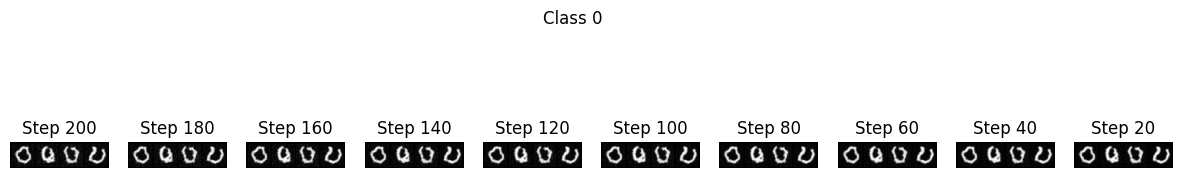

Sampling: 100%|██████████| 200/200 [03:49<00:00,  1.15s/it]


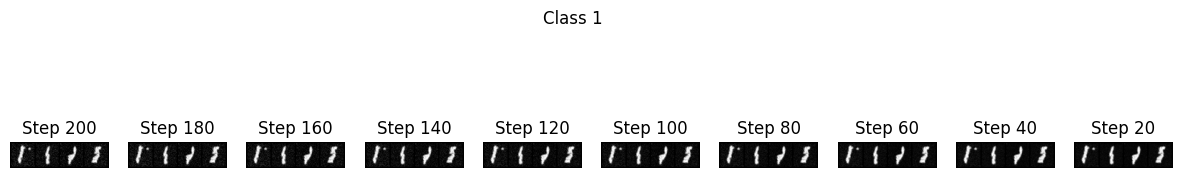

Sampling:  27%|██▋       | 54/200 [00:59<02:48,  1.15s/it]

In [ ]:
for class_label in range(10):
    class_labels = torch.full((4,), class_label, device=device)
    sample_images_list = sampling(model, (4, 1, image_size, image_size), class_labels)
    plot_intermediate_steps(sample_images_list, class_label)